In [215]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from pandas_datareader import data as pdr
import yfinance as yf
import seaborn as sns
yf.pdr_override()

import warnings
warnings.filterwarnings('ignore')

# prepare data

In [2]:
capital = 1e5
start_date = dt.datetime(2004,11,1)
end_date = dt.datetime(2023,11,1)
spy = pdr.get_data_yahoo("SPY", start = start_date, end = end_date)

[*********************100%%**********************]  1 of 1 completed


In [122]:
Y = np.log(spy["Adj Close"]).diff(1).shift(-1)
'''
(aim) use today's x var to predeict today's return
'''
            
Y.name = "Y_pred"
print(Y.index[0])
print(Y.index[-1])
print(Y.shape)

2004-11-01 00:00:00
2023-10-31 00:00:00
(4783,)


In [5]:
tnx_ticker = "^TNX" # CBOE 10 Year Treasury Note Yield Index
tnx_data = yf.download(tnx_ticker, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [94]:
X0 = np.log(tnx_data['Adj Close'])
X0 = X0.ffill()
X0.name='10years futures'
print(X0.index[0])
print(X0.index[-1])
print(X0.shape)

2004-11-01 00:00:00
2023-10-31 00:00:00
(4777,)


In [95]:
vix_ticker = "^VIX"
vix = yf.download(vix_ticker, start=start_date, end=end_date)
print(vix.index[0])
print(vix.index[-1])
print(vix.shape)

[*********************100%%**********************]  1 of 1 completed
2004-11-01 00:00:00
2023-10-31 00:00:00
(4783, 6)


In [96]:
X0_1 = np.log(vix['Adj Close'])
X0_1 = X0_1.ffill()
X0_1.name='vix'
print(X0_1.index[0])
print(X0_1.index[-1])
print(X0_1.shape)

2004-11-01 00:00:00
2023-10-31 00:00:00
(4783,)


In [97]:
X1 = np.log(spy['Volume'])
print(X1.index[0])
print(X1.index[-1])
print(X1.shape)

2004-11-01 00:00:00
2023-10-31 00:00:00
(4783,)


In [98]:
X2 = pd.concat([Y.diff(i) for i in [3,6,12]], axis=1)
X2.columns = ["SPY_3", "SPY_6", "SPY_12"]
print(X2.index[0])
print(X2.index[-1])
print(X2.shape)

2004-11-01 00:00:00
2023-10-31 00:00:00
(4783, 3)


In [99]:
X3 = pd.concat([X1.shift(i) for i in [3,6,12]], axis=1)
X3.columns = ["Volume_3", "Volume_6", "Volume_12"]

print(X3.index[0])
print(X3.index[-1])
print(X3.shape)

2004-11-01 00:00:00
2023-10-31 00:00:00
(4783, 3)


In [121]:
X = pd.concat([X0, X0_1, X1, X2, X3], axis=1)

> volume lag 12 --> data start from 2004-11-17

In [115]:
X_traintest = X.loc[pd.to_datetime('2004-11-17'):]
X_traintest = X_traintest.ffill()

Y_traintest = Y.loc[pd.to_datetime('2004-11-17'):]

In [21]:
Y_traintest_binary = (Y_traintest > 0).astype(int)

In [145]:
index_ = Y_traintest_binary.index

# basic data prepared

In [177]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=3)
X_poly = poly.fit_transform(X_traintest)
X_poly.shape


# - original x var = 9
# - degree-1 term = 9
# - degree-2 terms 
#     - 9
#     - interaction 9C2 = 36
# - degree-3 terms
#     - 9
#     - 9C3 = 84
#     - degree-2 term + other degree-1 term = 9 * 8 = 72
# - constant term = 1

# - 9(original)+9(squared)+36(pairwise)+9(cubed)+84(three-way)+72(squared-other)+1(constant)=220


(4771, 220)

In [179]:
feature_names = poly.get_feature_names_out(input_features=['10years futures', 'vix', 'Volume', 'SPY_3', 'SPY_6', 'SPY_12', 'Volume_3', 'Volume_6', 'Volume_12'])
X_poly_df = pd.DataFrame(X_poly, columns=feature_names)
X_poly_df.index = index_

In [166]:
index_

DatetimeIndex(['2004-11-17', '2004-11-18', '2004-11-19', '2004-11-22',
               '2004-11-23', '2004-11-24', '2004-11-26', '2004-11-29',
               '2004-11-30', '2004-12-01',
               ...
               '2023-10-18', '2023-10-19', '2023-10-20', '2023-10-23',
               '2023-10-24', '2023-10-25', '2023-10-26', '2023-10-27',
               '2023-10-30', '2023-10-31'],
              dtype='datetime64[ns]', name='Date', length=4771, freq=None)

In [168]:
# check data
print(Y_traintest_binary.shape)
print(X_poly.shape)
print(len(index_))

print(Y_traintest_binary.index[0])
print(X_poly.index[0])
print(index_[0])

print(Y_traintest_binary.index[-1])
print(X_poly.index[-1])
print(index_[-1])

(4771,)
(4771, 220)
4771
2004-11-17 00:00:00
2004-11-17 00:00:00
2004-11-17 00:00:00
2023-10-31 00:00:00
2023-10-31 00:00:00
2023-10-31 00:00:00


In [196]:
from sklearn.feature_selection import SelectKBest, f_regression
selector = SelectKBest(score_func=f_regression, k=10) 
# select the top 10 features based on the F-scores

X_selected = selector.fit_transform(X_poly_df, Y_traintest_binary) #Y_traintest_binary
print(X_selected.shape)

X_columns = selector.get_feature_names_out()
print(X_columns)

X_selected_df = pd.DataFrame(X_selected, columns = X_columns)
X_selected_df.index = index_
print(X_selected_df.shape)

(4771, 10)
['SPY_3' 'SPY_6' 'SPY_12' 'Volume SPY_12' 'SPY_12 Volume_3'
 'SPY_12 Volume_6' 'SPY_12 Volume_12' 'Volume^2 SPY_12'
 'Volume SPY_12 Volume_3' 'Volume SPY_12 Volume_6']
(4771, 10)


In [200]:
X_selected_df

,SPY_3,SPY_6,SPY_12,Volume SPY_12,SPY_12 Volume_3,SPY_12 Volume_6,SPY_12 Volume_12,Volume^2 SPY_12,Volume SPY_12 Volume_3,Volume SPY_12 Volume_6
Date,,,,,,,,,,
2004-11-17,-0.001106,0.000579,0.000996,0.017751,0.017770,0.017552,0.017357,0.316203,0.316554,0.312670
2004-11-18,-0.003994,-0.018759,-0.023694,-0.409350,-0.411782,-0.417675,-0.422806,-7.072212,-7.114233,-7.216046
2004-11-19,-0.001163,-0.003102,-0.008805,-0.156805,-0.154124,-0.153634,-0.159880,-2.792635,-2.744889,-2.736168
2004-11-22,0.000176,-0.000930,-0.004720,-0.082321,-0.084078,-0.084171,-0.084152,-1.435806,-1.466442,-1.468072
2004-11-23,0.013546,0.009552,0.003818,0.067014,0.065961,0.066353,0.068582,1.176252,1.157772,1.164651
...,...,...,...,...,...,...,...,...,...,...
2023-10-25,-0.010312,0.001368,-0.017238,-0.316514,-0.321227,-0.312655,-0.313774,-5.811573,-5.898098,-5.740718
2023-10-26,-0.012054,0.004282,-0.008631,-0.160207,-0.158272,-0.158414,-0.156911,-2.973727,-2.937821,-2.940453
2023-10-27,0.026341,0.024249,0.018000,0.332852,0.327230,0.335051,0.323098,6.155018,6.051054,6.195692


# select model - elasticNet + logisticRegression, long only

- elastic net
    - elastic net is a regularisation technique that is a balance between ridge (L2) regularisation and lasso (L1) regularisation
        - L2: square-of-coefficient penalty, prevent overfitting by shrinking coef, but dont set coefficients to 0
        - L1: ab-of-coef penalty, can set coef to 0, but poor perform against highly correlated var
    - l1_ratio: in this case, lower l1_ratio is better because: 
        - the X_selected_df vars are highly correlated
        - to keep all 10 features done from k-means
        
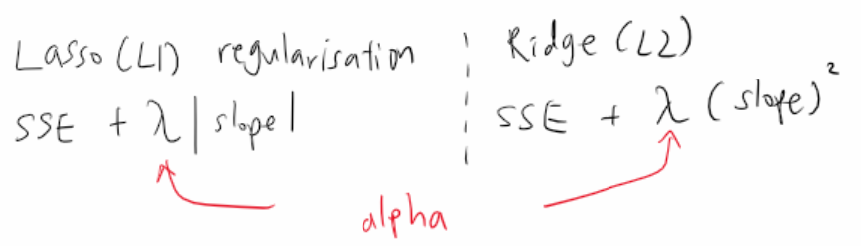

<Axes: >

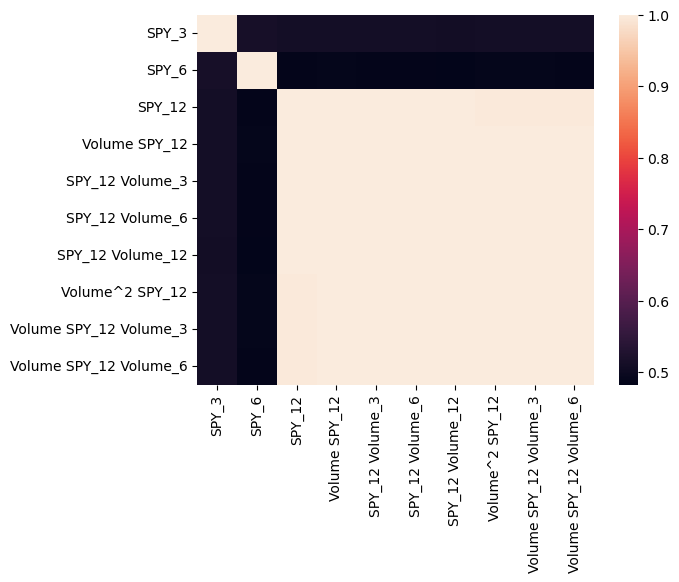

In [204]:
sns.heatmap(X_selected_df.corr())

In [209]:
penalty_ = 0
elastic_net = ElasticNet(alpha=0.1, l1_ratio= penalty_)
elastic_net.fit(X_selected_df, Y_traintest_binary)

In [211]:
elastic_net.coef_

array([0.01906677, 0.0199621 , 0.00146418, 0.01433851, 0.01399885,
       0.01368377, 0.01307979, 0.01671575, 0.01072411, 0.00534134])

In [217]:
elastic_net.intercept_

0.5468336247896721

In [219]:
EN_pred_train2 = elastic_net.predict(X_selected_df)

[0.55814645 0.2904143  0.44740496 ... 0.76688173 0.68255968 0.68182474]


In [231]:
EN_pred_train2_df = pd.DataFrame(EN_pred_train2, columns = ['predicted'])
EN_pred_train2_df.index = index_

In [239]:
Y_pred_binary2 = (EN_pred_train2_df > 0 ).astype(int)

In [241]:
from sklearn.linear_model  import LogisticRegression
logreg_sk2 = LogisticRegression(penalty='elasticnet', l1_ratio=penalty_, solver='saga')
logreg_sk2.fit(X_selected_df, Y_pred_binary2)
print(logreg_sk2.coef_)
print(logreg_sk2.intercept_)

[[-0.00100593  0.00011145 -0.00157924 -0.01347798 -0.0110337  -0.01188692
  -0.01382503  0.05849535  0.10357721  0.08552412]]
[4.5993026]


In [249]:
Y_pred_logistic2 = logreg_sk2.predict(X_selected_df)

Y_pred_logistic2_df = pd.DataFrame(Y_pred_logistic2, columns=['predicted'])
Y_pred_logistic2_df.index = index_

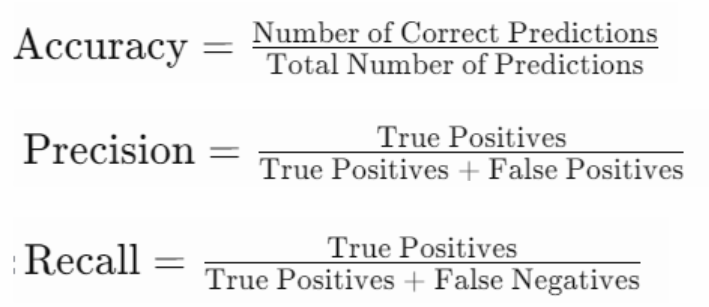

In [258]:
from sklearn import metrics
from sklearn.metrics import mean_squared_error
print(metrics.accuracy_score(Y_traintest_binary,Y_pred_logistic2_df))
print(metrics.precision_score(Y_traintest_binary,Y_pred_logistic2_df))
print(metrics.recall_score(Y_traintest_binary,Y_pred_logistic2_df))

0.5537623139802976
0.5509083227714406
0.9988510149368058


In [260]:
Y_traintest_binary.value_counts()

Y_pred
1    2611
0    2160
Name: count, dtype: int64

In [261]:
Y_pred_logistic2_df.value_counts()

predicted
1            4734
0              37
Name: count, dtype: int64

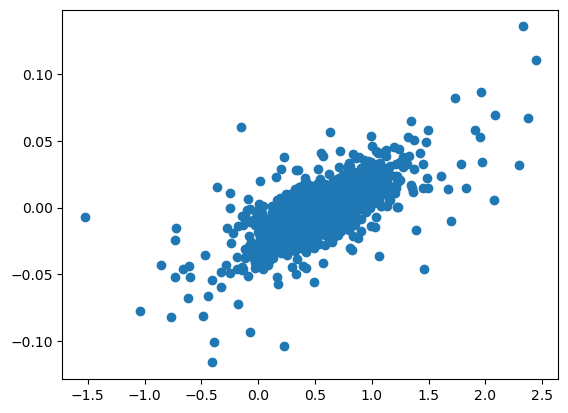

In [274]:
plt.scatter(EN_pred_train2, Y_traintest)

# positive linear relationship predictions are close to actual values

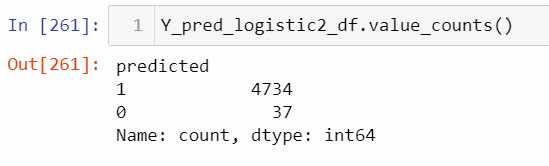

Y_pred_logistic2_df has mostly 1 and this is weird. In comparison, Y_traintest_binary has about 50% 1

In [283]:
X_traintest3 = X.copy()
X_traintest3["signal"] =  Y_pred_logistic2_df
X_traintest3 = X_traintest3.loc[pd.to_datetime('2004-11-17'):]
X_traintest3 = X_traintest3.ffill()
print(X_traintest3.shape)
print(X_traintest3.isna().sum())

(4771, 10)
10years futures    0
vix                0
Volume             0
SPY_3              0
SPY_6              0
SPY_12             0
Volume_3           0
Volume_6           0
Volume_12          0
signal             0
dtype: int64


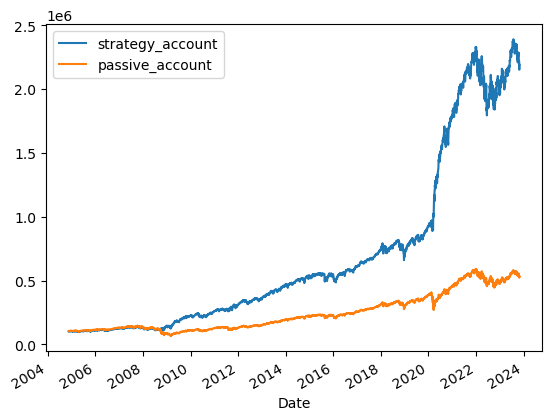

In [300]:
X_traintest3['strategy_return'] = X_traintest3["signal"] * Y
capital = 100000
X_traintest3['strategy_account'] = X_traintest3['strategy_return'].cumsum().apply(np.exp) * capital
X_traintest3['passive_account'] = Y.cumsum().apply(np.exp) * capital


fig, ax1 = plt.subplots()
X_traintest3['strategy_account'].plot(ax=ax1, label='strategy_account')
X_traintest3['passive_account'].plot(ax=ax1, label='passive_account')
ax1.legend()

In [299]:
X_traintest3['strategy_cum_return']

Date
2004-11-17    1.001349e+05
2004-11-18    9.902177e+04
2004-11-19    9.949403e+04
2004-11-22    9.964579e+04
2004-11-23    9.988193e+04
                  ...     
2023-10-25    2.162695e+06
2023-10-26    2.152892e+06
2023-10-27    2.178631e+06
2023-10-30    2.192314e+06
2023-10-31             NaN
Name: strategy_cum_return, Length: 4771, dtype: float64

# optimsation

In [334]:
res1 = pd.DataFrame(columns =['balance', 'degree', 'k','alpha', 'penalty_'])


res1 = res1
degree=3
k=10
alpha=0.1
penalty_=0
solver= 'saga'
capital = 100000

# 'saga' is solver of choice for elastic net 
poly = PolynomialFeatures(degree=degree)
X_poly = poly.fit_transform(X_traintest)
X_poly.shape

feature_names = poly.get_feature_names_out(input_features=['10years futures', 'vix', 'Volume', 'SPY_3', 'SPY_6', 'SPY_12', 'Volume_3', 'Volume_6', 'Volume_12'])
X_poly_df = pd.DataFrame(X_poly, columns=feature_names)
X_poly_df.index = index_

selector = SelectKBest(score_func=f_regression, k=k) 
# select the top 10 features based on the F-scores

X_selected = selector.fit_transform(X_poly_df, Y_traintest_binary) #Y_traintest_binary

X_columns = selector.get_feature_names_out()

X_selected_df = pd.DataFrame(X_selected, columns = X_columns)
X_selected_df.index = index_

elastic_net = ElasticNet(alpha=alpha, l1_ratio= penalty_)
elastic_net.fit(X_selected_df, Y_traintest_binary)

EN_pred_train2 = elastic_net.predict(X_selected_df)

EN_pred_train2_df = pd.DataFrame(EN_pred_train2, columns = ['predicted'])
EN_pred_train2_df.index = index_

#     print(metrics.accuracy_score(Y_traintest_binary,Y_pred_logistic2_df))
#     print(metrics.precision_score(Y_traintest_binary,Y_pred_logistic2_df))
#     print(metrics.recall_score(Y_traintest_binary,Y_pred_logistic2_df))


Y_pred_binary2 = (EN_pred_train2_df > 0 ).astype(int)

logreg_sk2 = LogisticRegression(penalty='elasticnet', l1_ratio=penalty_, solver=solver)
logreg_sk2.fit(X_selected_df, Y_pred_binary2)

Y_pred_logistic2 = logreg_sk2.predict(X_selected_df)

Y_pred_logistic2_df = pd.DataFrame(Y_pred_logistic2, columns=['predicted'])
Y_pred_logistic2_df.index = index_

X_traintest3 = X.copy()
X_traintest3["signal"] =  Y_pred_logistic2_df
X_traintest3 = X_traintest3.loc[pd.to_datetime('2004-11-17'):]
X_traintest3 = X_traintest3.ffill()

X_traintest3['strategy_return'] = X_traintest3["signal"] * Y
capital = capital
X_traintest3['strategy_account'] = X_traintest3['strategy_return'].cumsum().apply(np.exp) * capital
X_traintest3['passive_account'] = Y.cumsum().apply(np.exp) * capital

balance = X_traintest3['strategy_account'].dropna()[-1]
res1.loc[len(res1)] = [balance, degree, k, alpha, penalty_]

In [358]:
def optimise1(res1 = res1, degree=3, k=10, alpha=0.1, penalty_=0, solver= 'saga', capital = 100000): 
    # 'saga' is solver of choice for elastic net 
    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(X_traintest)
    X_poly.shape

    feature_names = poly.get_feature_names_out(input_features=['10years futures', 'vix', 'Volume', 'SPY_3', 'SPY_6', 'SPY_12', 'Volume_3', 'Volume_6', 'Volume_12'])
    X_poly_df = pd.DataFrame(X_poly, columns=feature_names)
    X_poly_df.index = index_

    selector = SelectKBest(score_func=f_regression, k=k) 
    # select the top 10 features based on the F-scores

    X_selected = selector.fit_transform(X_poly_df, Y_traintest_binary) #Y_traintest_binary

    X_columns = selector.get_feature_names_out()

    X_selected_df = pd.DataFrame(X_selected, columns = X_columns)
    X_selected_df.index = index_
    
    elastic_net = ElasticNet(alpha=alpha, l1_ratio= penalty_)
    elastic_net.fit(X_selected_df, Y_traintest_binary)
    
    EN_pred_train2 = elastic_net.predict(X_selected_df)
    
    EN_pred_train2_df = pd.DataFrame(EN_pred_train2, columns = ['predicted'])
    EN_pred_train2_df.index = index_
    
#     print(metrics.accuracy_score(Y_traintest_binary,Y_pred_logistic2_df))
#     print(metrics.precision_score(Y_traintest_binary,Y_pred_logistic2_df))
#     print(metrics.recall_score(Y_traintest_binary,Y_pred_logistic2_df))
    
    
    Y_pred_binary2 = (EN_pred_train2_df > 0 ).astype(int)
    if len(Y_pred_binary2['predicted'].unique()) == 1: return None
    
    logreg_sk2 = LogisticRegression(penalty='elasticnet', l1_ratio=penalty_, solver=solver)
    
    logreg_sk2.fit(X_selected_df, Y_pred_binary2)
    
    Y_pred_logistic2 = logreg_sk2.predict(X_selected_df)

    Y_pred_logistic2_df = pd.DataFrame(Y_pred_logistic2, columns=['predicted'])
    Y_pred_logistic2_df.index = index_
    
    X_traintest3 = X.copy()
    X_traintest3["signal"] =  Y_pred_logistic2_df
    X_traintest3 = X_traintest3.loc[pd.to_datetime('2004-11-17'):]
    X_traintest3 = X_traintest3.ffill()
    
    X_traintest3['strategy_return'] = X_traintest3["signal"] * Y
    capital = capital
    X_traintest3['strategy_account'] = X_traintest3['strategy_return'].cumsum().apply(np.exp) * capital
    X_traintest3['passive_account'] = Y.cumsum().apply(np.exp) * capital

    balance = X_traintest3['strategy_account'].dropna()[-1]
    res1.loc[len(res1)] = [balance, degree, k, alpha, penalty_]

In [359]:
degree_list = [2,3]
k_list = [5,8,10,15]
alpha_list = [0.1,0.2,0.3]
penalty_list = [0, 0.1, 0.2]

combi = [(degree, k, alpha, penalty_)
         for degree in degree_list
         for k in k_list
         for alpha in alpha_list
         for penalty_ in penalty_list]

In [360]:
res1 = pd.DataFrame(columns =['balance', 'degree', 'k','alpha', 'penalty_'])

for degree, k, alpha, penalty_ in combi:
    optimise1(res1, degree=degree, k=k, alpha=alpha, penalty_=penalty_, solver= 'saga', capital = 100000)

In [303]:
k_list = range(5,10,1)
for each in k_list:
    print(each)

5
6
7
8
9


In [310]:
res1 = pd.DataFrame(columns =['strategy_balance', 'degree', 'k','alpha', 'penalty_'])
res1

,strategy_balance,degree,k,alpha,penalty_


In [330]:
res1.sort_values('balance')

,balance,degree,k,alpha,penalty_


In [378]:
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows', None)
res1.sort_values('balance', ascending=False)

,balance,degree,k,alpha,penalty_
24,1.004708e+07,2.0,15.0,0.1,0.0
27,7.149503e+06,2.0,15.0,0.2,0.0
25,5.430823e+06,2.0,15.0,0.1,0.1
16,5.195577e+06,2.0,10.0,0.1,0.0
30,4.275227e+06,2.0,15.0,0.3,0.0
26,3.089247e+06,2.0,15.0,0.1,0.2
17,3.037408e+06,2.0,10.0,0.1,0.1
40,2.825431e+06,3.0,8.0,0.1,0.0
41,2.825431e+06,3.0,8.0,0.1,0.1
46,2.825431e+06,3.0,8.0,0.3,0.0


In [363]:
res1.sort_values('balance')

,balance,degree,k,alpha,penalty_
37,5.076915e+05,3.0,5.0,0.2,0.2
39,5.076915e+05,3.0,5.0,0.3,0.1
13,5.076915e+05,2.0,8.0,0.2,0.2
5,5.076915e+05,2.0,5.0,0.2,0.2
7,5.076915e+05,2.0,5.0,0.3,0.1
...,...,...,...,...,...
30,4.275227e+06,2.0,15.0,0.3,0.0
16,5.195577e+06,2.0,10.0,0.1,0.0
25,5.430823e+06,2.0,15.0,0.1,0.1
27,7.149503e+06,2.0,15.0,0.2,0.0


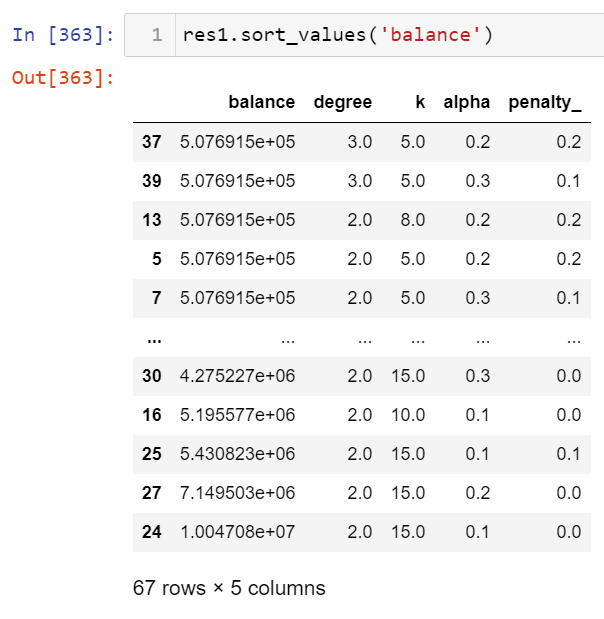

In [381]:
# degree_list = [2,3]
# k_list = [5,8,10,15]
# alpha_list = [0.1,0.2,0.3]
# penalty_list = [0, 0.1, 0.2]

# combi = [(degree, k, alpha, penalty_)
#          for degree in degree_list
#          for k in k_list
#          for alpha in alpha_list
#          for penalty_ in penalty_list]

# res1 = pd.DataFrame(columns =['balance', 'degree', 'k','alpha', 'penalty_'])

# for degree, k, alpha, penalty_ in combi:
#     optimise1(res1, degree=degree, k=k, alpha=alpha, penalty_=penalty_, solver= 'saga', capital = 100000)

# balance	degree	k	alpha	penalty_
# 24	1.004708e+07	2.0	15.0	0.1	0.0
# 27	7.149503e+06	2.0	15.0	0.2	0.0
# 25	5.430823e+06	2.0	15.0	0.1	0.1
# 16	5.195577e+06	2.0	10.0	0.1	0.0
# 30	4.275227e+06	2.0	15.0	0.3	0.0
# 26	3.089247e+06	2.0	15.0	0.1	0.2
# 17	3.037408e+06	2.0	10.0	0.1	0.1
# 40	2.825431e+06	3.0	8.0	0.1	0.0
# 41	2.825431e+06	3.0	8.0	0.1	0.1
# 46	2.825431e+06	3.0	8.0	0.3	0.0
# 43	2.825431e+06	3.0	8.0	0.2	0.0
# 19	2.739984e+06	2.0	10.0	0.2	0.0
# 44	2.729793e+06	3.0	8.0	0.2	0.1
# 42	2.729793e+06	3.0	8.0	0.1	0.2
# 8	2.609233e+06	2.0	8.0	0.1	0.0
# 47	2.582152e+06	3.0	8.0	0.3	0.1
# 45	2.582152e+06	3.0	8.0	0.2	0.2
# 48	2.577718e+06	3.0	8.0	0.3	0.2
# 49	2.192314e+06	3.0	10.0	0.1	0.0
# 55	2.192314e+06	3.0	10.0	0.3	0.0
# 52	2.192314e+06	3.0	10.0	0.2	0.0
# 50	2.093853e+06	3.0	10.0	0.1	0.1
# 53	2.093853e+06	3.0	10.0	0.2	0.1
# 51	2.093853e+06	3.0	10.0	0.1	0.2
# 54	2.093853e+06	3.0	10.0	0.2	0.2
# 56	2.093853e+06	3.0	10.0	0.3	0.1
# 32	1.936299e+06	3.0	5.0	0.1	0.0
# 0	1.936299e+06	2.0	5.0	0.1	0.0
# 9	1.921712e+06	2.0	8.0	0.1	0.1
# 57	1.874320e+06	3.0	10.0	0.3	0.2
# 11	1.838151e+06	2.0	8.0	0.2	0.0
# 28	1.688077e+06	2.0	15.0	0.2	0.1
# 59	1.680771e+06	3.0	15.0	0.1	0.1
# 58	1.680771e+06	3.0	15.0	0.1	0.0
# 60	1.680771e+06	3.0	15.0	0.1	0.2
# 61	1.680771e+06	3.0	15.0	0.2	0.0
# 62	1.680771e+06	3.0	15.0	0.2	0.1
# 63	1.680771e+06	3.0	15.0	0.2	0.2
# 64	1.680771e+06	3.0	15.0	0.3	0.0
# 65	1.680771e+06	3.0	15.0	0.3	0.1
# 66	1.680771e+06	3.0	15.0	0.3	0.2
# 22	1.579596e+06	2.0	10.0	0.3	0.0
# 33	1.546196e+06	3.0	5.0	0.1	0.1
# 1	1.546196e+06	2.0	5.0	0.1	0.1
# 18	1.407644e+06	2.0	10.0	0.1	0.2
# 35	1.390373e+06	3.0	5.0	0.2	0.0
# 3	1.390373e+06	2.0	5.0	0.2	0.0
# 10	1.222990e+06	2.0	8.0	0.1	0.2
# 20	1.185994e+06	2.0	10.0	0.2	0.1
# 31	1.161854e+06	2.0	15.0	0.3	0.1
# 2	1.122317e+06	2.0	5.0	0.1	0.2
# 34	1.122317e+06	3.0	5.0	0.1	0.2
# 14	1.114660e+06	2.0	8.0	0.3	0.0
# 38	9.496976e+05	3.0	5.0	0.3	0.0
# 6	9.496976e+05	2.0	5.0	0.3	0.0
# 12	8.758173e+05	2.0	8.0	0.2	0.1
# 23	7.528653e+05	2.0	10.0	0.3	0.1
# 4	7.499816e+05	2.0	5.0	0.2	0.1
# 36	7.499816e+05	3.0	5.0	0.2	0.1
# 29	7.488695e+05	2.0	15.0	0.2	0.2
# 21	6.577331e+05	2.0	10.0	0.2	0.2
# 15	5.524077e+05	2.0	8.0	0.3	0.1
# 37	5.076915e+05	3.0	5.0	0.2	0.2
# 13	5.076915e+05	2.0	8.0	0.2	0.2
# 7	5.076915e+05	2.0	5.0	0.3	0.1
# 5	5.076915e+05	2.0	5.0	0.2	0.2
# 39	5.076915e+05	3.0	5.0	0.3	0.1

In [439]:
def optimise2(long_short = True, res = None, degree=3, k=10, alpha=0.1, penalty_=0, solver= 'saga', capital = 100000): 
    # 'saga' is solver of choice for elastic net 
    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(X_traintest)
    X_poly.shape

    feature_names = poly.get_feature_names_out(input_features=['10years futures', 'vix', 'Volume', 'SPY_3', 'SPY_6', 'SPY_12', 'Volume_3', 'Volume_6', 'Volume_12'])
    X_poly_df = pd.DataFrame(X_poly, columns=feature_names)
    X_poly_df.index = index_

    selector = SelectKBest(score_func=f_regression, k=k) 
    # select the top 10 features based on the F-scores

    X_selected = selector.fit_transform(X_poly_df, Y_traintest_binary) #Y_traintest_binary

    X_columns = selector.get_feature_names_out()

    X_selected_df = pd.DataFrame(X_selected, columns = X_columns)
    X_selected_df.index = index_
    
    elastic_net = ElasticNet(alpha=alpha, l1_ratio= penalty_)
    elastic_net.fit(X_selected_df, Y_traintest_binary)
    
    EN_pred_train2 = elastic_net.predict(X_selected_df)
    
    EN_pred_train2_df = pd.DataFrame(EN_pred_train2, columns = ['predicted'])
    EN_pred_train2_df.index = index_
    
#     print(metrics.accuracy_score(Y_traintest_binary,Y_pred_logistic2_df))
#     print(metrics.precision_score(Y_traintest_binary,Y_pred_logistic2_df))
#     print(metrics.recall_score(Y_traintest_binary,Y_pred_logistic2_df))
    
    if long_short is True: 
        Y_pred_binary2_df = np.sign(EN_pred_train2_df)
    
    if len(Y_pred_binary2['predicted'].unique()) == 1: return None
    
    logreg_sk2 = LogisticRegression(penalty='elasticnet', l1_ratio=penalty_, solver=solver)
    
    logreg_sk2.fit(X_selected_df, Y_pred_binary2)
    
    Y_pred_logistic2 = logreg_sk2.predict(X_selected_df)

    Y_pred_logistic2_df = pd.DataFrame(Y_pred_logistic2, columns=['predicted'])
    Y_pred_logistic2_df.index = index_
    
    X_traintest3 = X.copy()
    X_traintest3["signal"] =  Y_pred_logistic2_df
    X_traintest3 = X_traintest3.loc[pd.to_datetime('2004-11-17'):]
    X_traintest3 = X_traintest3.ffill()
    
    X_traintest3['strategy_return'] = X_traintest3["signal"] * Y
    capital = capital
    X_traintest3['strategy_account'] = X_traintest3['strategy_return'].cumsum().apply(np.exp) * capital
    X_traintest3['passive_account'] = Y.cumsum().apply(np.exp) * capital

    balance = X_traintest3['strategy_account'].dropna()[-1]
    res.loc[len(res)] = [balance, degree, k, alpha, penalty_]

In [442]:
degree_list = [2,3]
k_list = [5,8,10,15]
alpha_list = [0.1,0.2,0.3]
penalty_list = [0, 0.1, 0.2]

combi = [(degree, k, alpha, penalty_)
        for degree in degree_list
        for k in k_list
        for alpha in alpha_list
        for penalty_ in penalty_list]

res2 = pd.DataFrame(columns =['balance', 'degree', 'k','alpha', 'penalty_'])

for degree, k, alpha, penalty_ in combi:
    optimise2(long_short=True, res = res2, degree=degree, k=k, alpha=alpha, penalty_=penalty_, solver= 'saga', capital = 100000)

In [443]:
res2.sort_values('balance', ascending=False)

,balance,degree,k,alpha,penalty_
40,3.029540e+07,3.0,5.0,0.2,0.1
43,3.029540e+07,3.0,5.0,0.3,0.1
1,3.029540e+07,2.0,5.0,0.1,0.1
38,3.029540e+07,3.0,5.0,0.1,0.2
8,3.029540e+07,2.0,5.0,0.3,0.2
7,3.029540e+07,2.0,5.0,0.3,0.1
37,3.029540e+07,3.0,5.0,0.1,0.1
5,3.029540e+07,2.0,5.0,0.2,0.2
4,3.029540e+07,2.0,5.0,0.2,0.1
44,3.029540e+07,3.0,5.0,0.3,0.2


# CART (classification and regression decision tree)
- (classification) builds a binary tree that splits datasets into subsets (e.g. of diff years) to predict future
- (regression) mse
- pros:
    - capable of handling complex nonlinear relatinoships
- cons:
    - prone to overfitting 
    - small data change can lead to diff splits

In [544]:
Y_traintest

Date
2004-11-17    0.001348
2004-11-18   -0.011179
2004-11-19    0.004758
2004-11-22    0.001524
2004-11-23    0.002367
2004-11-24   -0.000760
2004-11-26   -0.004574
2004-11-29    0.000679
2004-11-30    0.011303
2004-12-01    0.000838
2004-12-02   -0.000670
2004-12-03   -0.000336
2004-12-06   -0.009355
2004-12-07    0.005826
2004-12-08    0.003529
2004-12-09    0.001006
2004-12-10    0.008678
2004-12-13    0.003483
2004-12-14    0.000745
2004-12-15   -0.000579
2004-12-16   -0.006693
2004-12-17    0.000251
2004-12-20    0.007671
2004-12-21    0.002406
2004-12-22    0.000746
2004-12-23   -0.002073
2004-12-27    0.005461
2004-12-28    0.001484
2004-12-29   -0.001897
2004-12-30   -0.002149
2004-12-31   -0.004727
2005-01-03   -0.012295
2005-01-04   -0.006925
2005-01-05    0.005071
2005-01-06   -0.001434
2005-01-07    0.004717
2005-01-10   -0.006915
2005-01-11    0.003295
2005-01-12   -0.008044
2005-01-13    0.005257
2005-01-14    0.010349
2005-01-18   -0.010518
2005-01-19   -0.006110
2005-0

In [545]:
DT_pred_train2

array([ 0.00134838, -0.01117882,  0.00475793, ...,  0.01188488,
        0.00626063,  0.00626063])

In [550]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
DT_model = DecisionTreeRegressor(criterion='squared_error')
DT_model.fit(X_selected_df, Y_traintest.ffill())
DT_pred_train2 = DT_model.predict(X_selected_df)
train_result_mse = mean_squared_error(Y_traintest.ffill(), DT_pred_train2)
print('mse = ', train_result_mse)

DT_pred_train2_df = pd.DataFrame(DT_pred_train2, index=index_, )

X_traintest_dt = X_selected_df.copy()
X_traintest_dt['signal'] = DT_pred_train2_df
X_traintest_dt['signal'] = np.sign(X_traintest_dt['signal'])

mse =  0.0


strategy final balance =  1.3544955853277257e+21


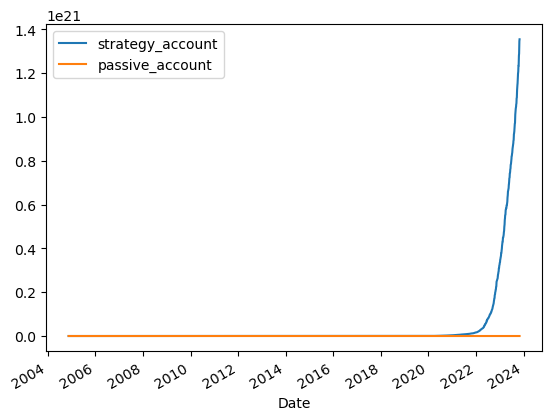

In [553]:
X_traintest_dt['strategy_return'] = X_traintest_dt["signal"] * Y
capital = 100000
X_traintest_dt['strategy_account'] = X_traintest_dt['strategy_return'].cumsum().apply(np.exp) * capital
X_traintest_dt['passive_account'] = Y.cumsum().apply(np.exp) * capital


fig, ax1 = plt.subplots()
X_traintest_dt['strategy_account'].plot(ax=ax1, label='strategy_account')
X_traintest_dt['passive_account'].plot(ax=ax1, label='passive_account')
ax1.legend()

print('strategy final balance = ', X_traintest_dt['strategy_account'].dropna()[-1])

<font color = 'red'>

> elastic net
- independet var
    - raw = Y
    - Y_traintest
    - Y_traintest_binary
    
- predicted
    - EN_pred_train2 (non-binary)
    - EN_pred_train2_df (binary)
    - binary = Y_pred_logistic2_df
        - elasticNet + logisticRegression 
            - long only --> (store in 'res1') highest balance 1.005e+07, degree 2, k 15, alpha 0.1, penalty 0
            - long short --> (store in 'res2') highest balance 3.03e+07, degree 3, k 5, alpha 0.2, penalty 0.1
     

- indepedent var 
    - raw  = X
    - X_traintest
    - PolynomialFeatures = X_poly_df
    - kmeans = X_selected_df

- index = index_
    
- 4771
- 2004-11-17 to 2023-10-31
    
- stacking models: to correct error in model1, feed model1 prediction into model2
    - elastic net: benefit from regularisation
    - logistic regression: benefit from
        - specialisation in binary task
        - make use of performance metrics (e.g. accuracy, precision, recall)
    
> cart 
- x var (data from diff years) = df_dict
- Y
    - predicted (long short): DT_pred_train2
        - 100% overfitting, mse=0, strategy final balance = 1.3544955853277257e+21